# About This Notebook

Concatenate
Remove Contractions
I want to remove numbers and symbols
Stop Word Creation
Top 25 Words
IDF Values
Parts of Speech Analysis
Preprocessing with Count Vect (for modeling)


### Import Libraries

In [202]:
#Standard Libraries
import pandas as pd
import numpy as np

# Importing Visualization Libraries
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'black' # setting default background color
import seaborn as sns

# NLP Libraries
from nltk import FreqDist, pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re #regex
import contractions #contractions library

# Scikit Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import text


### Read in Data

In [3]:
wine = pd.read_csv('../data/wine.csv', )

In [4]:
beer = pd.read_csv('../data/beer.csv')

In [5]:
wine.head(1)

,title,selftext,subreddit
0,Resources for a newbie home winemaker,Resources for a newbie home winemaker I want t...,winemaking


In [6]:
beer.head(1)

,title,selftext,subreddit
0,Sitrep Monday,"Sitrep Monday You've had a week, what's your s...",Homebrewing


Dropping title column from both DFs. The text from the column has already been merged to selftext in the previous notebook. 

In [7]:
wine.drop(columns = 'title', inplace = True)

In [8]:
beer.drop(columns = 'title', inplace = True)

In [9]:
wine.columns

Index(['selftext', 'subreddit'], dtype='object')

In [10]:
beer.columns

Index(['selftext', 'subreddit'], dtype='object')

# PREPROCESSING

# Concatenating 
wine and beer dataframes into one df on the row index 

In [11]:
posts_df = pd.concat([wine, beer], ignore_index = True)

Saving posts_df to CSV

In [12]:
posts_df.to_csv('../data/wine_beer_concatenated.csv', index = False)

In [13]:
posts_df.head(1)

,selftext,subreddit
0,Resources for a newbie home winemaker I want t...,winemaking


In [14]:
posts_df.tail(1)

,selftext,subreddit
4301,Does a decoction mash with wheat leave a bread...,Homebrewing


### Expanding Contractions
* The code for this section has been adapted from this article in Towards Data Science. 
* https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28


**Creating a new column 'no_contraction'.**
* by applying a lambda function to 'selftext' column that takes in a word from a post in a series that has been split.
* if the word is a contraction it converts it to two words using the **fix function** from the **Contrations Library** imported above. 

In [15]:
posts_df['no_contraction'] = posts_df['selftext'].apply(lambda x: 
[contractions.fix(word) for word in x.split()])

**Converting the lists in 'no_contraction' series back to string objects.**
* creating a list comprehension that joins mappings of str conversions to a list for every list in 'no_contraction' series. 

In [16]:
posts_df['no_contraction_str'] = [' '.join(map(str, l)) for l in posts_df['no_contraction']]

In [17]:
posts_df.head(1)

,selftext,subreddit,no_contraction,no_contraction_str
0,Resources for a newbie home winemaker I want t...,winemaking,"[Resources, for, a, newbie, home, winemaker, I...",Resources for a newbie home winemaker I want t...


**Make 'selftext' column the 'no_contraction_str' column**

In [18]:
posts_df['selftext'] = posts_df['no_contraction_str']

In [19]:
posts_df = posts_df.drop(columns = ['no_contraction', 'no_contraction_str'])

In [20]:
posts_df.head(1)

,selftext,subreddit
0,Resources for a newbie home winemaker I want t...,winemaking


## Getting Rid of Symbols and Numbers

**Removing Numbers**

In [21]:
posts_df['selftext'] = posts_df['selftext'].str.replace('\d+', ' ')

In [22]:
posts_df.head(1)

,selftext,subreddit
0,Resources for a newbie home winemaker I want t...,winemaking


**Removing Symbols**

In [23]:
posts_df['selftext'] = posts_df['selftext'].str.replace('[^\w\s]',' ')

In [24]:
posts_df.head(1)

,selftext,subreddit
0,Resources for a newbie home winemaker I want t...,winemaking


**Stripping White Space**

In [25]:
posts_df['selftext'] = posts_df['selftext'].str.strip(' ')

In [26]:
posts_df.head(1)

,selftext,subreddit
0,Resources for a newbie home winemaker I want t...,winemaking


**Making Everything Lowercase**

In [27]:
posts_df['selftext'] = posts_df['selftext'].str.lower()

In [28]:
posts_df.head(1)

,selftext,subreddit
0,resources for a newbie home winemaker i want t...,winemaking


## Stop Word Creation
inspired by these links:
* https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list
* https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In [29]:
my_stop_words = ['just', 'like', 'make', 'add', 'know', 'use', 'does', 'good', 'did', 'https', 'com', 'time', 'want', 'got', 'used', 'use', 'really', 'using', 'little', 'think', 'imgur', 'imgur com', 'added', 'days', 'day', 'need', 'going', 'looking', 'new']

**Appending my stop_words to preloaded CountVec stop words**

In [30]:
stop_words_custom = text.ENGLISH_STOP_WORDS.union(my_stop_words)

**Appending nltk_stopwords to CountVec stopwords**
I feel this will add a bit more robustness and diversity to the stop words. 


In [31]:
nltk_stopwords = list(stopwords.words('english'))

In [32]:
stop_words_custom = stop_words_custom.union(nltk_stopwords)

In [33]:
len(stop_words_custom)

403

### Taking Stop Words out of Posts_DF
helped by this article:
https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

In [34]:
posts_df['selftext']

0       resources for a newbie home winemaker i want t...
1       a question about kit wine i have made quite a ...
2       riesling   my first wine hi everyone  i am goi...
3       persimmon wine straining  hello  this is my fi...
4       wire used for trellis hey all   i am planting ...
                              ...                        
4297    any input on this recipe   lb   pale malt  mar...
4298    bottling tepache hello brewers  a couple days ...
4299    wiring a spa panel for ebiab gfi i have been a...
4300    what can i ferment at     f  the basement in t...
4301    does a decoction mash with wheat leave a bread...
Name: selftext, Length: 4302, dtype: object

In [35]:
posts_df['stop_out'] = posts_df['selftext'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words_custom]))

In [36]:
posts_df['selftext'] = posts_df['stop_out']

In [37]:
posts_df.drop(columns = ['stop_out'], inplace = True)

In [38]:
posts_df.head(1)

,selftext,subreddit
0,resources newbie home winemaker comprehensive ...,winemaking


____________________
# EDA

## Creating seperate df's for homebrewing and winemaking

In [39]:
brew = posts_df[posts_df['subreddit'] == 'Homebrewing']
wine = posts_df[posts_df['subreddit'] == 'winemaking']

In [40]:
brew.head(1)

,selftext,subreddit
1935,sitrep monday week situation report feel free ...,Homebrewing


In [41]:
wine.head(1)

,selftext,subreddit
0,resources newbie home winemaker comprehensive ...,winemaking


## Instantiating CountVectorizers

Instantiating 2 seperate Count Vectorizers. One for Homebrewing DF and one for winemaking DF. I am doing this separately in order to analyze each df's word trends seperately. I will then do a merged count vectorizer to analyze these trends when they are together. 

**Brew Count Vectorizer**

In [42]:
cvec_brew = CountVectorizer(stop_words = stop_words_custom, ngram_range = (1,3))
cvec_wine = CountVectorizer(stop_words = stop_words_custom,  ngram_range = (1,3))

**Wine Count Vectorizer**

In [43]:
brew_vec = cvec_brew.fit_transform(brew['selftext'])
wine_vec = cvec_wine.fit_transform(wine['selftext'])

## Top 25 Words in Beer Subreddit
* After stop words are removed
* After basic preprocessing with CountVectorizer

The code to achieve this was inspired by this site:
https://stackoverflow.com/questions/16078015/list-the-words-in-a-vocabulary-according-to-occurrence-in-a-text-corpus-with-sc

In [44]:
sum_brew = brew_vec.sum(axis = 0)

In [45]:
word_freq_brew = [(word, sum_brew[0, idx]) for word, idx in cvec_brew.vocabulary_.items()] 

**Creating a DF with top 25 Words in Homebrewing**

In [46]:
beer_25 = sorted(word_freq_brew, key = lambda x: x[1], reverse = True)[:25]

In [47]:
beer_25_df = pd.DataFrame(beer_25)

In [48]:
beer_25_df.rename(columns = {0: 'word', 1: 'count'}, inplace = True)

### Top 25 Words Homebrewing

In [49]:
beer_25_df.head(2)

,word,count
0,beer,1457
1,yeast,1137


## Top 25 Words in Wine Subreddit
* After stop words are removed
* After basic preprocessing with CountVectorizer

The code to achieve this was inspired by this site:
https://stackoverflow.com/questions/16078015/list-the-words-in-a-vocabulary-according-to-occurrence-in-a-text-corpus-with-sc

* [X] Do some stop word analysis here. 
* [X] Add common words to the stop words list
* [X] Words like ferment and fermentation should be added to stop words because they exist very frequently in both subreddits. 
* [X] Common words such as just, like, https, com and more will need to be removed as well. 

In [50]:
sum_wine = wine_vec.sum(axis = 0)

In [51]:
word_freq_wine = [(word, sum_wine[0, idx]) for word, idx in cvec_wine.vocabulary_.items()] 

**Creating a DF with Top 25 Words in Winemaking**

In [52]:
wine_25 = sorted(word_freq_wine, key = lambda x: x[1], reverse = True)[:25];

In [53]:
wine_25_df = pd.DataFrame(wine_25)

In [54]:
wine_25_df.rename(columns = {0: 'word', 1: 'count'}, inplace = True)

### Top 25 Words Winemaking

In [55]:
wine_25_df.head(2)

,word,count
0,wine,3526
1,yeast,968


## Top 25 Word Charts

**Top 25 Words Homebrewing Chart**

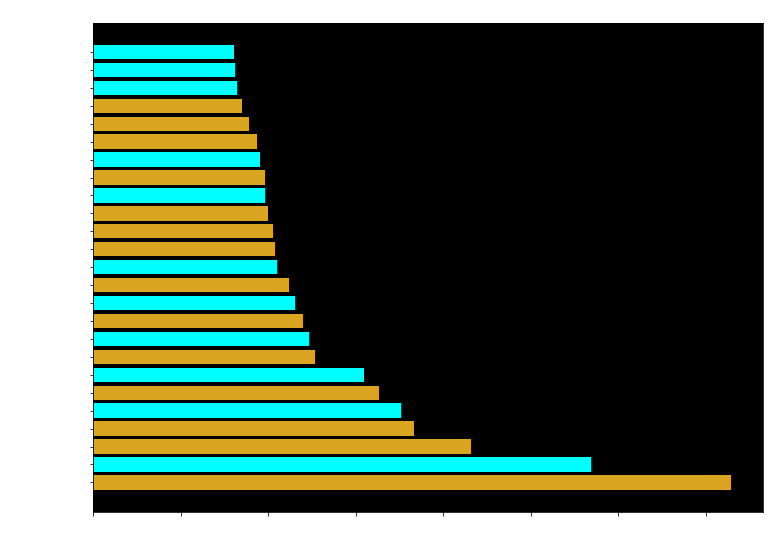

In [209]:
brew_color_list = ['goldenrod', 'aqua', 'goldenrod', 'goldenrod', 
                   'aqua','goldenrod', 'aqua','goldenrod', 
                   'aqua','goldenrod', 'aqua','goldenrod', 
                   'aqua','goldenrod', 'goldenrod','goldenrod', 
                   'aqua','goldenrod', 'aqua','goldenrod', 
                   'goldenrod','goldenrod', 'aqua','aqua', 'aqua',]

x = list(beer_25_df['count'])
bars = list(beer_25_df['word'])
y_pos = np.arange(len(bars))
plt.figure(figsize = (12,9))
plt.barh(y_pos, x, color = brew_color_list)
plt.yticks(y_pos, bars, color = 'white')
plt.xticks(color = 'white')
plt.xlabel('Word Count', color = 'white')
plt.ylabel('Word', color = 'white')
plt.title('Top 25 Words HomeBrewing Subreddit', color = 'white')
plt.show()

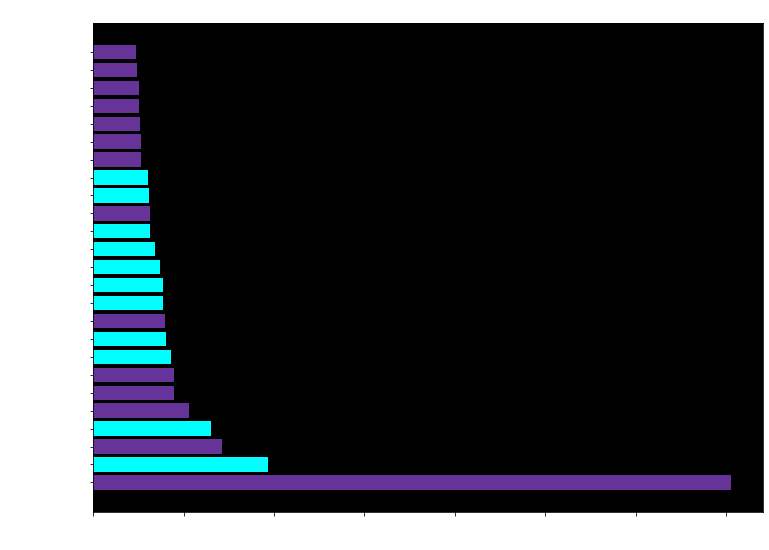

In [212]:
wine_color_list = ['rebeccapurple', 'aqua', 'rebeccapurple', 'aqua', 
                   'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'aqua', 
                   'aqua', 'rebeccapurple', 'aqua', 'aqua', 
                   'aqua', 'aqua', 'aqua', 'rebeccapurple', 
                   'aqua', 'aqua', 'rebeccapurple', 'rebeccapurple', 
                   'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple','rebeccapurple',]




x = list(wine_25_df['count'])
bars = list(wine_25_df['word'])
y_pos = np.arange(len(bars))

plt.figure(figsize = (12,9))
plt.barh(y_pos, x, color = wine_color_list)
plt.yticks(y_pos, bars, color = 'white')
plt.xticks(color = 'white')
plt.xlabel('Word Count', color = 'white')
plt.ylabel('Word', color = 'white')
plt.title('Top 25 Words Winemaking Subreddit', color = 'white')
plt.show()

In [157]:
shared_words = []
for word in wine_25_df['word']:
    for word2 in beer_25_df['word']:
        if word == word2:
            shared_words.append(word)
print(f'Shared Words: {shared_words}')

Shared Words: ['yeast', 'fermentation', 'batch', 'amp', 'bottle', 'water', 'gallon', 'thanks', 'question', 'help', 'recipe']


### Analysis of Top 25 Word Charts

Not surprisingly the top word in Winemaking is 'wine' and the top word in Homebrewing is 'beer.' Also not surprising are other shared words in the top 25 such as fermentation, water and yeast. 

I think there are some distincive words in each of these lists that will make a prediciting model very successful. In the homebrewing list words like beer, brew, keg, hops and grain will add distinguishing capability to the model. In the winemaking list words like wine, grapes, primary and secondary will add distinguishing capability to the model.

### Outliers and Overly Frequent Words

After reviewing these charts it will likely be necessary to remove the terms 'wine', 'beer', 'brew' and 'brewing' from the corpus as these counts may make the model overpredictive to many of these features. 

In the case of words like 'yeast', 'fermentation', 'batch', 'amp', 'bottle', 'water', 'gallon', 'thanks', 'question', 'help' and 'recipe' it may be necessary to remove these words because they appear frequently in both models. 
___________________________

_________________________________
# IDF Values
The lower the IDF value of a word, the less unique it is to any particular document

Used this website for guidance on this process:
https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X_DmeulKhTY

I used Tfidf Transformer instead of Tfidf Vectorizer.
Tf = term frequency
Tf-idf = term frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification. 

The goal of using tf-idf instead of the raw frequencies of occurence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus. 

Notes on TfidfTransformer Hyperparameters:
* smooth_idf was used (True is default), the constant 1 is added ot the numerator and denominator of the idf as if an extra document was seen continaing every term in collection exactly once, this prevents zero division. 
* use_idf (True is default), enables inverse-document-frequency reweighting. 

**Brew TFIDF**

In [59]:
tfidf_trans_brew = TfidfTransformer(smooth_idf = True, use_idf = True)
tfidf_trans_brew.fit(brew_vec)

TfidfTransformer()

**Wine TFIDF**

In [60]:
tfidf_trans_wine = TfidfTransformer(smooth_idf = True, use_idf = True)
tfidf_trans_wine.fit(wine_vec)

TfidfTransformer()

**Creating a DataFrame of IDF Values**

In [61]:
idf_brew_df = pd.DataFrame(tfidf_trans_brew.idf_, 
                           index = cvec_brew.get_feature_names(), 
                           columns = ['idf_weights'])
idf_wine_df = pd.DataFrame(tfidf_trans_wine.idf_, 
                           index = cvec_wine.get_feature_names(), 
                           columns = ['idf_weights'])

In [62]:
idf_brew_df['idf_weights'].nsmallest(50);

In [63]:
idf_wine_df['idf_weights'].nsmallest(50);

In [64]:
idf_brew_df['idf_weights'].nlargest(50)

__                            8.076654
__ ktbpkd                     8.076654
__ ktbpkd mmf                 8.076654
___                           8.076654
___ post                      8.076654
___ post sitrep               8.076654
___ tip                       8.076654
___ tip lot                   8.076654
__________                    8.076654
__________ amarillo           8.076654
__________ amarillo hops      8.076654
__both__                      8.076654
__both__ uuk                  8.076654
__both__ uuk zpc              8.076654
__https                       8.076654
__https streamable            8.076654
__https streamable __         8.076654
__https streamable eyz__      8.076654
__https streamable jkujb__    8.076654
__https streamable oy         8.076654
__https streamable pz         8.076654
__mk_nl_nl                    8.076654
__mk_nl_nl åmåžõñ             8.076654
__mk_nl_nl åmåžõñ amp         8.076654
_a _rookie                    8.076654
_a _rookie _mistake      

In [65]:
idf_wine_df['idf_weights'].nlargest(50);

# Parts of Speech Analysis using NLTK

**Create list of posts to be tokenized for each subreddit**

In [66]:
brew_text = list(brew['selftext'])
wine_text = list(wine['selftext'])

**Tokenize using NLTK word tokenizer**

In [68]:
brew_tokens = [word_tokenize(i) for i in brew_text]
wine_tokens = [word_tokenize(i) for i in wine_text]

In [73]:
#creating a list of words from wine subreddit to pos tag
wine_tag_list = []
for lst in wine_tokens:
    for item in lst:
        wine_tag_list.append(item)
len(wine_tag_list) #checking to make sure the list was created correctly

80939

In [74]:
# creating a list of words from wine subreddit to pos tag
brew_tag_list = []
for lst in brew_tokens:
    for item in lst:
        brew_tag_list.append(item)
len(brew_tag_list) #checking to make sure the list was created correctly

114936

In [ ]:
c = Counter(word_list)

In [ ]:
# 5 most common in the firt post
len(c.most_common())

**Executing Part-of-Speech tagging using Penn Treebank tags**

In [75]:
wine_tag = pos_tag(wine_tag_list)

In [76]:
brew_tag = pos_tag(brew_tag_list)

**Creating DF's for Tagged Parts of Speech and their Words in Each Subreddit**

##### Wine Tags DF

In [77]:
wine_tag_df = pd.DataFrame(wine_tag, columns = ['word', 'part_of_speech'])

In [78]:
wine_tag_df.head(1)

,word,part_of_speech
0,resources,NNS


In [109]:
total_words_wine = len(wine_tag_df)
total_words_wine

80939

##### Brew Tags DF

In [80]:
brew_tag_df = pd.DataFrame(brew_tag, columns = ['word', 'part_of_speech'])

In [82]:
brew_tag_df.head(1)

,word,part_of_speech
0,sitrep,NN


In [110]:
total_words_brew = len(brew_tag_df)
total_words_brew

114936

**Checking for nulls. There are none**

In [83]:
wine_tag_df.isnull().sum()

word              0
part_of_speech    0
dtype: int64

In [84]:
brew_tag_df.isnull().sum()

word              0
part_of_speech    0
dtype: int64

**Link to NLTK Tag Set**
https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [90]:
wine_pos_values = wine_tag_df['part_of_speech'].value_counts()
wine_pos_values[:5]

NN     32447
JJ     16450
NNS     8715
VBG     5609
VBP     4078
Name: part_of_speech, dtype: int64

In [88]:
brew_pos_values = brew_tag_df['part_of_speech'].value_counts()
brew_pos_values[:5]

NN     48718
JJ     22388
NNS    10880
VBG     6984
VBD     6662
Name: part_of_speech, dtype: int64

In [106]:
brew_pos_value_df = pd.DataFrame(brew_pos_values)
brew_pos_value_df.head(1)

,part_of_speech
NN,48718


In [107]:
wine_pos_value_df = pd.DataFrame(wine_pos_values)
wine_pos_value_df.head(1)

,part_of_speech
NN,32447


In [111]:
brew_pos_value_df['pos_perc_of_words'] = brew_pos_value_df['part_of_speech'] / total_words_brew

In [112]:
wine_pos_value_df['pos_perc_of_words'] = wine_pos_value_df['part_of_speech'] / total_words_wine

In [116]:
brew_pos_value_df.head(10)

,part_of_speech,pos_perc_of_words
NN,48718,0.423871
JJ,22388,0.194787
NNS,10880,0.094661
VBG,6984,0.060764
VBD,6662,0.057963
RB,5321,0.046295
VBP,5188,0.045138
VBN,2539,0.022091
VBZ,1694,0.014739
VB,1396,0.012146


In [117]:
wine_pos_value_df.head(10)

,part_of_speech,pos_perc_of_words
NN,32447,0.400882
JJ,16450,0.203239
NNS,8715,0.107674
VBG,5609,0.069299
VBP,4078,0.050384
VBD,4035,0.049852
RB,3910,0.048308
VBN,1784,0.022041
VBZ,1179,0.014567
VB,959,0.011848


**Wine Parts of Speech Stats**

In [149]:
wine_adjectives = (wine_pos_value_df['pos_perc_of_words']['JJ'] +
                   wine_pos_value_df['pos_perc_of_words']['JJR'] +
                   wine_pos_value_df['pos_perc_of_words']['JJS']) * 100
f'Wine Adjectives = {round(wine_adjectives, ndigits = 2)} Percent of Words'

'Wine Adjectives = 21.02 Percent of Words'

In [148]:
wine_nouns = (wine_pos_value_df['pos_perc_of_words']['NN'] +
                   wine_pos_value_df['pos_perc_of_words']['NNS']) * 100
f'Wine Nouns = {round(wine_nouns, ndigits = 2)} Percent of Words'

'Wine Nouns = 50.86 Percent of Words'

In [147]:
wine_adverbs = (wine_pos_value_df['pos_perc_of_words']['RB'] +
                   wine_pos_value_df['pos_perc_of_words']['RBR'] +
                   wine_pos_value_df['pos_perc_of_words']['RBS']) * 100
f'Wine Adverbs = {round(wine_adverbs, ndigits = 2)} Percent of Words'

'Wine Adverbs = 5.14 Percent of Words'

In [132]:
wine_verbs = (wine_pos_value_df['pos_perc_of_words']['VB'] +
                   wine_pos_value_df['pos_perc_of_words']['VBD'] +
                   wine_pos_value_df['pos_perc_of_words']['VBG'] +
             wine_pos_value_df['pos_perc_of_words']['VBN'] +
                   wine_pos_value_df['pos_perc_of_words']['VBP'] +
                   wine_pos_value_df['pos_perc_of_words']['VBZ']) * 100
f'Wine Verbs = {round(wine_verbs, ndigits = 2)} Percent of Words'

'Wine Verbs = 22.0 Percent of Words'

**Brewing Parts of Speech Stats**

In [146]:
brew_adjectives = (brew_pos_value_df['pos_perc_of_words']['JJ'] +
                   brew_pos_value_df['pos_perc_of_words']['JJR'] +
                   brew_pos_value_df['pos_perc_of_words']['JJS']) * 100
f'Brew Adjectives = {round(brew_adjectives, ndigits = 2)} Percent of Words'

'Brew Adjectives = 20.33 Percent of Words'

In [145]:
brew_nouns = (brew_pos_value_df['pos_perc_of_words']['NN'] +
                   brew_pos_value_df['pos_perc_of_words']['NNS']) * 100
f'Brew Nouns = {round(brew_nouns, ndigits = 2)} Percent of Words'

'Brew Nouns = 51.85 Percent of Words'

In [144]:
brew_adverbs = (brew_pos_value_df['pos_perc_of_words']['RB'] +
                   brew_pos_value_df['pos_perc_of_words']['RBR'] +
                   brew_pos_value_df['pos_perc_of_words']['RBS']) * 100
f'Brew Adverbs = {round(brew_adverbs, ndigits = 2)} Percent of Words'

'Brew Adverbs = 5.01 Percent of Words'

In [143]:
brew_verbs = (brew_pos_value_df['pos_perc_of_words']['VB'] +
                   brew_pos_value_df['pos_perc_of_words']['VBD'] +
                   brew_pos_value_df['pos_perc_of_words']['VBG'] +
             brew_pos_value_df['pos_perc_of_words']['VBN'] +
                   brew_pos_value_df['pos_perc_of_words']['VBP'] +
                   brew_pos_value_df['pos_perc_of_words']['VBZ']) * 100
f'Brew Verbs = {round(brew_verbs, ndigits = 2)} Percent of Words'

'Brew Verbs = 21.28 Percent of Words'

### Parts of Speech Chart

In [137]:
wine_pos_tags = [wine_adverbs, wine_adjectives, wine_verbs, wine_nouns]
brew_pos_tags = [brew_adverbs, brew_adjectives, brew_verbs, brew_nouns]

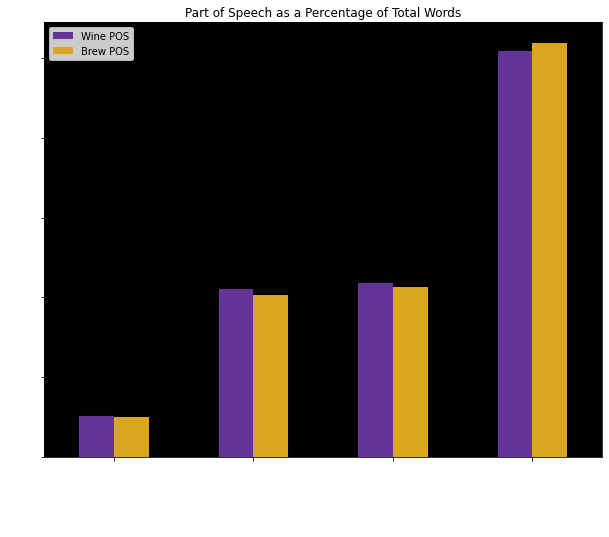

In [218]:
compare_tags = pd.DataFrame({'Wine POS': wine_pos_tags, 
                            'Brew POS': brew_pos_tags})
compare_tags.plot.bar(figsize = (10, 8), 
                      color = ['rebeccapurple', 'goldenrod']).set_title('Part of Speech as a Percentage of Total Words')
plt.legend(facecolor = 'white')
plt.yticks(color = 'white')
plt.xticks(ticks = [0, 1, 2, 3], labels = ['Adverbs', 'Adjectives', 'Verbs', 'Nouns'], color = 'white')
plt.ylabel('Percentage of Total Words', color = 'white')
plt.xlabel('Part of Speech', color = 'white');

## Parts of Speech Analysis

#### Nouns
* **NN means Noun, singular or mass.**
* **NNS is another form of Noun, plural.** 

Not surprising that it is the most common part of speech in both categories as nouns are a prominent part of all speech and especially when discussing tools used to produce things like wine and beer. 

#### Adjective
* **JJ mean Adjective**

another crucial part of every day language is found to be the 2nd most abundant part of speech used in both subreddits. 

#### Verbs
* **VBG means Verb gerund or present participle**
* **VBD means Verb, past tense**
* **VBP means Verb, 3rd person singular present.**

Verbs are also not suprisingly found amoung the most common words in both subredits. 

#### Final Thoughts of POS

I am disappointed that there are no glaring differences in POS of speech. However, what I do find interesting is the nearly identical numbers for both subreddits. The type of POS and the percentage of the respective POS in relation to total word count is almost identical in every category. This could be inspiration for further dives into POS research in groups that may not be so closely in common. It would be interesting to see if there can be some distinguishing characteristics. 

#### A Caveat

This POS analysis was done after stop words had been removed. This could have had an impact on the end results of the analysis. I think further research may also be necessary to compare POS before and after stop words are removed. If there is a difference it would be interesting to note if either subreddit used the stop words more or less than the other. This could have implications regarding command of language and perhaps culture of the different subreddits. 

### Finalizing Stop Words before Modeling

In [ ]:
# Find out if I should be taking these words out first. Then go to modeling. 

# Saving Pre-Processed posts_df to csv

In [219]:
posts_df.to_csv('../data/preprocessed_df.csv', index = False)